In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import PIL
import os, os.path

use_cuda=True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Loading

In [0]:
from zipfile import ZipFile
# import urllib.request
# url = 'https://github.com/SarhadSalam/APS360_Final_Project/blob/master/sample_data/trousers.zip'
file_name = "trousers.zip"
# urllib.request.urlretrieve(url, file_name)
ZipFile(file_name).extractall()

In [0]:
class EdgeRealDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transform = None):
      self.transform = transform
      self.count = len(dataset.samples) // 3
      #total_samples = len(dataset.samples) // 3
      #self.count = 5
      self.edges = [np.transpose(plt.imread(img[0]), [2, 0, 1]) for img in dataset.samples[:self.count]]
      self.real = [np.transpose(plt.imread(img[0]), [2, 0, 1]) for img in dataset.samples[self.count:self.count*2]]
      self.whites = [np.transpose(plt.imread(img[0]), [2, 0, 1]) for img in dataset.samples[self.count*2:]]
      #self.edges = [np.transpose(plt.imread(img[0]), [2, 0, 1]) for img in dataset.samples[:self.count]]
      #self.real = [np.transpose(plt.imread(img[0]), [2, 0, 1]) for img in dataset.samples[total_samples:total_samples + self.count]]
      #self.whites = [np.transpose(plt.imread(img[0]), [2, 0, 1]) for img in dataset.samples[total_samples * 2:total_samples * 2 + self.count]]
    
  def __len__(self):
      return self.count

  def __getitem__(self, idx):
      #if torch.is_tensor(idx):
      #    idx = idx.tolist()
      
      edge_img = self.whites[idx]
      real_img = self.real[idx]

      return (edge_img, real_img)

In [0]:
import PIL
def get_clothes_dataset():
    """
    Load the data into an ImageFolder dataset and print the number of data points
    Returns:
      full_data_set: ImageFolder dataset object with all the gesture data points
    """
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose([
        transforms.Resize((100,50)),
        transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))        
         ])
         
    
    # Get data
    dataset_path = "trousers/"
   
    def pil_loader_RGBA(path):
      # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
      with open(path, 'rb') as f:
          img = PIL.Image.open(f)
          return img.convert('RGBA')

    full_data_set = torchvision.datasets.ImageFolder(dataset_path, transform=transform, loader=pil_loader_RGBA)
    print("Number of data points is {}".format(len(full_data_set)))
    return full_data_set

In [0]:
data_set = get_clothes_dataset()

Number of data points is 1983


In [0]:
def get_data_loader(full_data_set, batch_size, data_samples = -1):
    """ Generates training, validation and testing data loader for the relevant 
    target classes for a given batch size.

    Args:
        full_data_set: Dataset object containing data points to be split into 
                        training, validation and test put into data loaders
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: size per batch
        data_samples: integer number of data samples to use, defaults to -1 to use all
                      data points
    Returns:
        training, validation and testing data loaders with a distribution of 
        60:30:10
    """
  
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    torch.manual_seed(1000)

    dataset = EdgeRealDataset(full_data_set)

    num_samples = len(dataset)
    #num_samples = 5

    # Randomize indices list
    indices = list(range(num_samples))
    np.random.shuffle(indices)

    train_sampler = SubsetRandomSampler(indices)

    train_loader = DataLoader(dataset, batch_size=batch_size,
                                num_workers=1, sampler=train_sampler)
    
    return train_loader

In [0]:
train_loader = get_data_loader(data_set, 1)

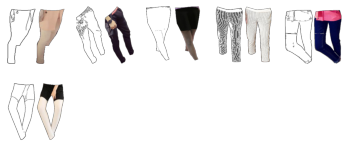

In [0]:
k = 0
for edges, reals in train_loader:
  # since batch_size = 1, there is only 1 image in `images`
  image = torch.cat((edges[0], reals[0]), dim=2)
  #image = edges[0]
  # place the colour channel at the end, instead of at the beginning
  img = np.transpose(image, [1,2,0])
  # normalize pixel intensity values to [0, 1]
  #img = img / 2 + 0.5
  plt.subplot(3, 5, k+1)
  plt.axis('off')
  plt.imshow(img)

  k += 1
  if k > 5:
    break

# GAN Architecture

In [0]:
class Generator(nn.Module):
  def __init__(self, name):
    super(Generator, self).__init__()
    self.name = name
    self.encoder= nn.Sequential(
      nn.Conv2d(4, 16, 3, stride=2, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 64, 7)
    )
    self.decoder= nn.Sequential(
      nn.ConvTranspose2d(64, 32, 7),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 4, 3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [0]:
class Discriminator(nn.Module):
  def __init__(self, name="cnn"):
    super(Discriminator,self).__init__()
    self.name = name

    in_ch1 = 4
    out_ch1 = 8
    kern_sz1 = 5
    stride1 = 1
    padding1 = 0

    pool1_kern_sz = 4
    pool1_stride = 4
    pool1_padding = 0

    in_ch2 = out_ch1
    out_ch2 = 16
    kern_sz2 = 5
    stride2 = 1
    padding2 = 0

    pool2_kern_sz = 2
    pool2_stride = 2
    pool2_padding = 0

    in_ch3 = out_ch2
    out_ch3 = 32
    kern_sz3 = 4
    stride3 = 1
    padding3 = 0      

    # Calculate size of output after convolution layers
    fc1_in_sz = 1 + int((400 + 2*padding1 - kern_sz1)/stride1)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool1_padding - pool1_kern_sz) / pool1_stride)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*padding2 - kern_sz2)/stride2)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool2_padding - pool2_kern_sz) / pool2_stride)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*padding3 - kern_sz3)/stride3)
    fc1_in_sz = 1 + int((fc1_in_sz + 2*pool2_padding - pool2_kern_sz) / pool2_stride)

    fc1_in_sz2 = 1 + int((100 + 2*padding1 - kern_sz1)/stride1)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool1_padding - pool1_kern_sz) / pool1_stride)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*padding2 - kern_sz2)/stride2)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool2_padding - pool2_kern_sz) / pool2_stride)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*padding3 - kern_sz3)/stride3)
    fc1_in_sz2 = 1 + int((fc1_in_sz2 + 2*pool2_padding - pool2_kern_sz) / pool2_stride)

    self.fc1_in_sz = out_ch3 * fc1_in_sz * fc1_in_sz2 # need to store on self for use in forward

    fc1_out_sz = 16

    fc2_in_sz = fc1_out_sz
    fc2_out_sz = 1

    # Three convolution layers (+ max pool)
    self.conv1 = nn.Conv2d(in_ch1, out_ch1, kern_sz1, stride1, padding1)
    self.pool1 = nn.MaxPool2d(pool1_kern_sz, pool1_stride, pool1_padding)
    self.conv2 = nn.Conv2d(in_ch2, out_ch2, kern_sz2, stride2, padding2)
    self.pool2 = nn.MaxPool2d(pool2_kern_sz, pool2_stride, pool2_padding)
    self.conv3 = nn.Conv2d(in_ch3, out_ch3, kern_sz3, stride3, padding3)
    
    # Two fully connected layers
    self.fc1 = nn.Linear(self.fc1_in_sz, fc1_out_sz)
    self.fc2 = nn.Linear(fc2_in_sz, fc2_out_sz)

  def forward(self, x):
    x = torch.cat([x[0], x[1]], dim=2)
    x = self.pool1(F.leaky_relu(self.conv1(x), 0.2))
    x = self.pool2(F.leaky_relu(self.conv2(x), 0.2))
    x = self.pool2(F.leaky_relu(self.conv3(x), 0.2))
    x = x.view(-1, self.fc1_in_sz)
    x = F.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    return x

In [0]:
def get_model_path(model, batch_size, learning_rate, num_epoch):
  return "model_{}_bs_{}_lr_{}_epoch_{}".format(model.name, batch_size,
                                                learning_rate, num_epoch)

In [0]:
def get_accuracy(D, G, loader):
  real_acc, fake_acc = 0., 0.
  total_real, total_fake = 0, 0
  for i, (source_real, target_real) in enumerate(loader, 0):
    real_labels = torch.ones(source_real.shape[0], 1)
    fake_labels = torch.zeros(source_real.shape[0], 1)

    if use_cuda and torch.cuda.is_available():
      real_labels = real_labels.cuda()
      fake_labels = fake_labels.cuda()

    if use_cuda and torch.cuda.is_available():
      source_real = source_real.cuda()
      target_real = target_real.cuda()

    out_D1 = D([source_real, target_real])

    if use_cuda and torch.cuda.is_available():
      out_D1 = out_D1.cuda()

    pred = [0 if x < 0.5 else 1 for x in out_D1]
    pred = torch.tensor(pred)
    if use_cuda and torch.cuda.is_available():
      pred = pred.cuda()
    real_acc += int((pred.squeeze() == real_labels.squeeze()).sum())
    total_real += real_labels.shape[0]

    #TODO try adding some noise to input before passing through generator
    target_fake = G(source_real)

    if use_cuda and torch.cuda.is_available():
      target_fake = target_fake.cuda()

    out_D2 = D([source_real, target_fake.detach()])

    if use_cuda and torch.cuda.is_available():
      out_D2 = out_D2.cuda()

    pred = [0 if x < 0.5 else 1 for x in out_D2]
    pred = torch.tensor(pred)
    if use_cuda and torch.cuda.is_available():
      pred = pred.cuda()
    fake_acc += int((pred.squeeze() == fake_labels.squeeze()).sum())
    total_fake += fake_labels.shape[0]
  
  return 100. * real_acc / total_real, 100. * fake_acc / total_fake

In [0]:
def train(G, D, batch_size=512, learning_rate=0.001, num_epochs=5):
  np.random.seed(1000)
  torch.manual_seed(1000)

  if use_cuda and torch.cuda.is_available():
    G = G.cuda()
    D = D.cuda()
    print('CUDA is available! Training on GPU')

  criterion_D = nn.BCELoss()
  optimizer_D = optim.Adam(D.parameters(), lr=learning_rate)
  criterion_G = nn.BCELoss()
  optimizer_G = optim.Adam(G.parameters(), lr=learning_rate)

  train_loader = get_data_loader(data_set, batch_size)
  print("Loaded training data with {} samples".format(len(train_loader.dataset)))
  real_labels = torch.ones(batch_size, 1)
  fake_labels = torch.zeros(batch_size, 1)

  model_store_interval = 100
  
  D_losses, D_acc_real, D_acc_fake, G_losses, iterations = [], [], [], [], []
  print("Started training")
  iteration = -1
  for epoch in range(num_epochs):
    print("Starting epoch", epoch+1)
    for i, (source_real, target_real) in enumerate(train_loader, 0):
      iteration += 1
      optimizer_D.zero_grad()

      real_labels = torch.ones(source_real.shape[0], 1)
      fake_labels = torch.zeros(source_real.shape[0], 1)

      if use_cuda and torch.cuda.is_available():
        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()

      if use_cuda and torch.cuda.is_available():
          source_real = source_real.cuda()
          target_real = target_real.cuda()

      out_D1 = D([source_real, target_real])

      if use_cuda and torch.cuda.is_available():
        out_D1 = out_D1.cuda()

      loss_D1 = criterion_D(out_D1, real_labels.float())

      #TODO try adding some noise to input before passing through generator
      target_fake = G(source_real)

      if use_cuda and torch.cuda.is_available():
        target_fake = target_fake.cuda()

      # if use_cuda and torch.cuda.is_available():
      #     target_fake = target_fake.cuda()

      out_D2 = D([source_real, target_fake.detach()])

      if use_cuda and torch.cuda.is_available():
        out_D2 = out_D2.cuda()

      loss_D2 = criterion_D(out_D2, fake_labels.float())

      loss_D = (loss_D1 + loss_D2) / 2
      loss_D.backward()
      optimizer_D.step()

      optimizer_G.zero_grad()

      out_D3 = D([source_real, target_fake])

      if use_cuda and torch.cuda.is_available():
        out_D3 = out_D3.cuda()

      loss_G = criterion_G(out_D3, real_labels)
      loss_G.backward()
      optimizer_G.step()

      # Save loss data
      if iteration % 50 == 0:
        iterations.append(iteration)
        D_losses.append(loss_D)
        acc_r, acc_f = get_accuracy(D, G, train_loader)
        D_acc_real.append(acc_r)
        D_acc_fake.append(acc_f)
        G_losses.append(loss_G)
        print("Iteration #{} |\t D_loss: {} |\t D_acc_r: {} |\t D_acc_f: {} |\t G_loss: {}".format(iteration, D_losses[-1], D_acc_real[-1], D_acc_fake[-1], G_losses[-1]))

    if (epoch == num_epochs-1 or (epoch+1) % model_store_interval == 0):
      model_path = get_model_path(D, batch_size, learning_rate, epoch)
      torch.save(D.state_dict(), model_path)
      model_path = get_model_path(G, batch_size, learning_rate, epoch)
      torch.save(G.state_dict(), model_path)

  print("Finished training")

  # Plots
  plt.title("D Losses")
  plt.plot(iterations, D_losses, label="D")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("D Accuracy")
  plt.plot(iterations, D_acc_real, label="Training Set")
  plt.plot(iterations, D_acc_fake, label="Generator Images")
  plt.xlabel("Iteration")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  plt.title("G Losses")
  plt.plot(iterations, G_losses, label="G")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [0]:
bs = 128
lr = 0.001
ne = 40000

generator = Generator("gen")
discriminator = Discriminator("dis")

train(generator, discriminator, bs, lr, ne)

CUDA is available! Training on GPU
Loaded training data with 661 samples
Started training
Starting epoch 1
Iteration #0 |	 D_loss: 0.6934564709663391 |	 D_acc_r: 0.0 |	 D_acc_f: 100.0 |	 G_loss: 0.7140122652053833
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Iteration #50 |	 D_loss: 0.027607757598161697 |	 D_acc_r: 99.3948562783661 |	 D_acc_f: 99.24357034795764 |	 G_loss: 6.361607551574707
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Iteration #100 |	 D_loss: 0.0031852922402322292 |	 D_acc_r: 100.0 |	 D_acc_f: 100.0 |	 G_loss: 9.884164810180664
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Iteration #150 |	 D_loss: 0.02151702716946602 |	 D_acc_r: 99.84871406959152 |	 D_acc_f: 98.789712

# Uhh


In [0]:
# Plot images for m to n

m, n = 0, 3
for i in range (m, n):
  test_edge_img = plt.imread('trousers/whites/' + str(i)+ '.png')
  test_real_img = plt.imread('trousers/filtered/' + str(i)+ '.png')
  test_edge_img_inp = torch.tensor(np.transpose(test_edge_img, [2, 0, 1]))
  test_edge_img_inp = test_edge_img_inp.reshape([1, *test_edge_img_inp.shape])

  if use_cuda and torch.cuda.is_available():
    test_edge_img_inp = test_edge_img_inp.cuda()

  out = generator(test_edge_img_inp)
  if use_cuda and torch.cuda.is_available():
    out = out.cpu().detach().numpy().squeeze(0)
  else:
    out = out.detach().numpy().squeeze(0)
  out = np.transpose(out, [1, 2, 0])

  plt.subplot(n-m, 3, 3 * (i-m) + 1)
  plt.axis('off')
  plt.imshow(test_edge_img)

  plt.subplot(n-m, 3, 3 * (i-m) + 2)
  plt.axis('off')
  plt.imshow(test_real_img)

  plt.subplot(n-m, 3, 3 * (i-m) + 3)
  plt.axis('off')
  plt.imshow(out)

In [0]:
def display_img_from_training(index):
  print("Plotting {}.png".format(index))

  test_edge_img = plt.imread('trousers/whites/' + str(index)+ '.png')
  test_real_img = plt.imread('trousers/filtered/' + str(index)+ '.png')
  test_edge_img_inp = torch.tensor(np.transpose(test_edge_img, [2, 0, 1]))
  test_edge_img_inp = test_edge_img_inp.reshape([1, *test_edge_img_inp.shape])

  if use_cuda and torch.cuda.is_available():
    test_edge_img_inp = test_edge_img_inp.cuda()

  out = generator(test_edge_img_inp)
  if use_cuda and torch.cuda.is_available():
    out = out.cpu().detach().numpy().squeeze(0)
  else:
    out = out.detach().numpy().squeeze(0)
  out = np.transpose(out, [1, 2, 0])

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.axis('off')
  plt.imshow(test_edge_img)

  plt.subplot(1, 3, 2)
  plt.title("Actual")
  plt.axis('off')
  plt.imshow(test_real_img)

  plt.subplot(1, 3, 3)
  plt.title("Generated")
  plt.axis('off')
  plt.imshow(out)

In [0]:
def display_img_from_custom(filename):
  print("Plotting " + filename)
  if filename[-4:] == '.png':
    filename = 'test_samples/' + filename
  else:
    filename = 'test_samples/' + filename + '.png'

  test_edge_img = plt.imread(filename)
  test_edge_img_inp = torch.tensor(np.transpose(test_edge_img, [2, 0, 1]))
  if test_edge_img_inp.shape[0] == 3:
    alpha = torch.ones(1, test_edge_img_inp.shape[1], test_edge_img_inp.shape[2])
    test_edge_img_inp = torch.cat([test_edge_img_inp, alpha])
  test_edge_img_inp = test_edge_img_inp.reshape([1, *test_edge_img_inp.shape])

  if use_cuda and torch.cuda.is_available():
    test_edge_img_inp = test_edge_img_inp.cuda()

  out = generator(test_edge_img_inp)
  if use_cuda and torch.cuda.is_available():
    out = out.cpu().detach().numpy().squeeze(0)
  else:
    out = out.detach().numpy().squeeze(0)
  out = np.transpose(out, [1, 2, 0])

  plt.subplot(1, 2, 1)
  plt.title("Input")
  plt.axis('off')
  plt.imshow(test_edge_img)

  plt.subplot(1, 2, 2)
  plt.title("Generated")
  plt.axis('off')
  plt.imshow(out)

In [0]:
def get_generator(name, bs, lr, epoch):
  generator = Generator(name)
  model_path = get_model_path(generator, bs, lr, epoch)
  state = torch.load(model_path)
  generator.load_state_dict(state)
  if use_cuda and torch.cuda.is_available():
    generator = generator.cuda()
  return generator

In [0]:
# Plot a random image
import random
i = random.randint(0, len(data_set) // 3)
display_img_from_training(i)